Shape: (550, 41)
Columns: ['city_mpg', 'class', 'combination_mpg', 'cylinders', 'displacement', 'drive', 'fuel_type', 'highway_mpg', 'make', 'model', 'transmission', 'year', 'mpg_diff', 'engine_efficiency', 'engine_power_density', 'size_category', 'drivetrain_type', 'vehicle_age', 'fuel_efficiency_category', 'is_high_performance', 'is_luxury', 'is_electric', 'is_diesel', 'is_hybrid', 'is_automatic', 'is_manual', 'make_encoded', 'class_encoded', 'drive_encoded', 'fuel_type_encoded', 'transmission_encoded', 'size_category_encoded', 'drivetrain_type_encoded', 'city_mpg_scaled', 'combination_mpg_scaled', 'cylinders_scaled', 'displacement_scaled', 'highway_mpg_scaled', 'year_scaled', 'vehicle_age_scaled', 'engine_efficiency_scaled']
Missing values:
 city_mpg                    0
class                       0
combination_mpg             0
cylinders                   0
displacement                0
drive                       0
fuel_type                   0
highway_mpg                 0
make 

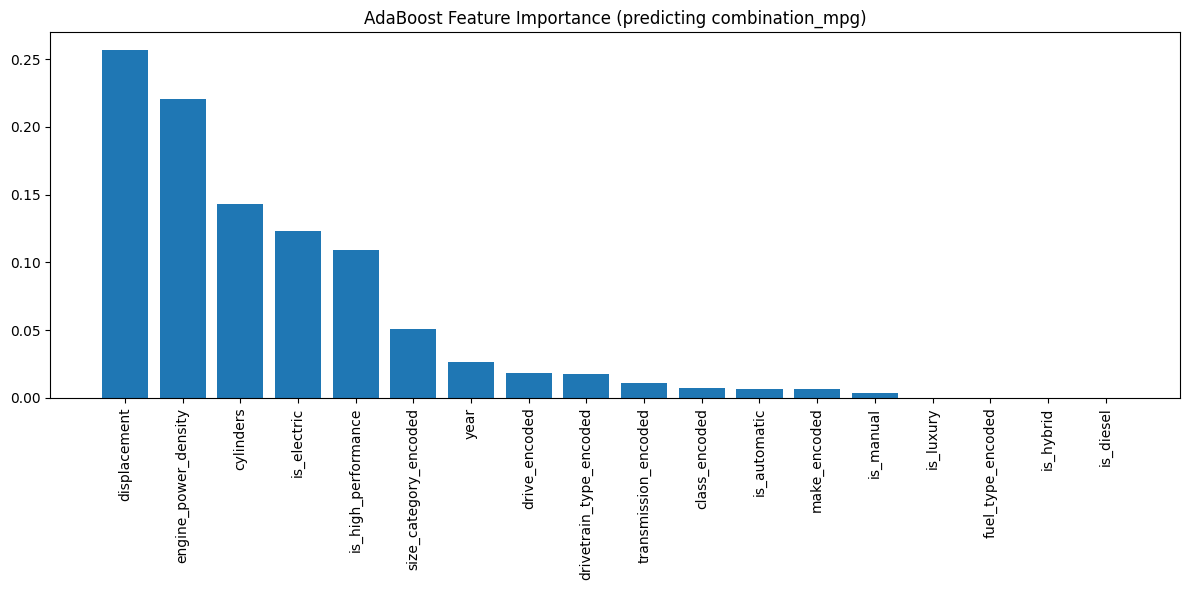

Train Score: 0.9561494762574229
Test Score: 0.5613696696353847


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ------------------------------
# 1. Load the dataset
# ------------------------------
df = pd.read_csv('Car Data P.csv')
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())

# ------------------------------
# 2. Sort chronologically
# ------------------------------
df = df.sort_values('year').reset_index(drop=True)

# ------------------------------
# 3. Define target and non‑leaky features
# ------------------------------
target = 'combination_mpg'

# Columns that would cause target leakage
leakage_cols = [
    'city_mpg', 'highway_mpg', 'mpg_diff',
    'engine_efficiency', 'fuel_efficiency_category',
    'combination_mpg_scaled', 'city_mpg_scaled', 'highway_mpg_scaled',
    'cylinders_scaled', 'displacement_scaled', 'year_scaled', 'vehicle_age_scaled',
    'engine_efficiency_scaled', 'vehicle_age',
    'model'   # too granular; would cause extreme sparsity
]

X = df.drop(columns=[target] + leakage_cols)
y = df[target]

# Keep only numeric columns (all remaining are numeric or encoded)
X = X.select_dtypes(include=[np.number])
print("\nFeatures used ({}) :".format(len(X.columns)))
print(X.columns.tolist())

# ------------------------------
# 4. Chronological train / test split
# ------------------------------
train_mask = df['year'] <= 2019
test_mask  = df['year'] >= 2020

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"\nTrain size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# ------------------------------
# 5. Feature scaling (not required for tree models, but harmless)
# ------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ------------------------------
# 6. AdaBoostRegressor with hyperparameter tuning
# ------------------------------
base_tree = DecisionTreeRegressor(max_depth=3, random_state=42)
ada = AdaBoostRegressor(
    estimator=base_tree,
    random_state=42
)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'loss': ['linear', 'square', 'exponential']
}

# TimeSeriesSplit respects chronological order within the training period
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    ada,
    param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print("\nBest parameters:", grid_search.best_params_)
print("Best CV MAE (neg):", -grid_search.best_score_)

# ------------------------------
# 7. Evaluate on the future test set (years ≥ 2020)
# ------------------------------
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nTest Set Performance (years 2020–2024):")
print(f"MAE  : {mae:.2f} mpg")
print(f"RMSE : {rmse:.2f} mpg")
print(f"R²   : {r2:.2f}")

# ------------------------------
# 8. Feature importance
# ------------------------------
importances = best_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("AdaBoost Feature Importance (predicting combination_mpg)")
plt.bar(range(len(indices[:20])), importances[indices[:20]])
plt.xticks(range(len(indices[:20])), feature_names[indices[:20]], rotation=90)
plt.tight_layout()
plt.show()
Train_Score = best_model.score(X_train_scaled, y_train)
Test_Score = best_model.score(X_test_scaled, y_test)
print("Train Score:", Train_Score)
print("Test Score:", Test_Score)